# Working With Reflection Coefficients and S-Parameters

In this demo, we will explore how to work with reflection coefficients and S-parameters using the `ReflectionCoefficient` and `SParams` classes from the `edges.cal` module.

## Imports and Setup

Most of the functionality we need lives in the `edges.cal.sparams` module, so we start by importing that, along with some other useful packages:

In [1]:
from edges.cal import sparams as sp

In [3]:
import numpy as np
from astropy import units as un
import matplotlib.pyplot as plt

## Defining Reflection Coefficients and S-Parameters

Reflection coefficients and S-parameters are fundamental concepts in RF engineering, representing how signals reflect and transmit through components. The `edges.cal.sparams` module provides classes to handle these concepts conveniently. A `ReflectionCoefficient` object represents a single reflection coefficient, while an `SParams` object can represent a full set of S-parameters for a multi-port network. Each of the classes also requires specifying the array of frequencies over which the parameters are defined. For example:

In [4]:
rc = sp.ReflectionCoefficient(
    freqs=np.linspace(50,100,101)*un.MHz,
    reflection_coefficient=np.ones(101)*0.5 + 1j*0.5
)

sparams = sp.SParams(
    freqs=np.linspace(50,100,101)*un.MHz,
    s11 = np.ones(101)*0.3 + 1j*0.4,
    s12 = np.ones(101)*0.1 + 1j*0.2,
    s21 = np.ones(101)*0.2 + 1j*0.1,
    s22 = np.ones(101)*0.4 + 1j*0.3,
)

The `ReflectionCoefficient` class can also read from a file containing S-parameter data in standard formats like `.s1p`, using the `.from_s1p()` method.

## Defining Reflection Coefficients and S-Parameters from Physical Models

Instead of manually specifying reflection coefficients or S-parameters, we can also derive them from physical models of components. The `edges.cal.sparams` module provides methods to create `ReflectionCoefficient` and `SParams` objects based on common RF components, such as transmission lines. 

In [11]:
transmission_line = sp.TransmissionLine(
    freqs = np.linspace(50,100,101)*un.MHz,
    resistance = 1*un.ohm/un.m,#attrs.field(validator=unv(un.ohm / un.m))
    inductance = 1*un.ohm*un.s/un.m, #attrs.field(validator=unv(un.ohm * un.s / un.m))
    conductance = 5e7 *un.siemens/un.m, #attrs.field(validator=unv(un.siemens / un.m))
    capacitance = 5e7*un.siemens * un.s/un.m, #attrs.field(validator=unv(un.siemens * un.s / un.m))
    length = 0.01*un.m
)

Then we have access to various properties of the transmission line, such as its characteristic impedance:

In [12]:
transmission_line.characteristic_impedance

<Quantity [0.00014142+0.00000000e+00j, 0.00014142+0.00000000e+00j,
           0.00014142+0.00000000e+00j, 0.00014142+0.00000000e+00j,
           0.00014142-2.40276900e-29j, 0.00014142+0.00000000e+00j,
           0.00014142-2.35743374e-29j, 0.00014142+0.00000000e+00j,
           0.00014142+0.00000000e+00j, 0.00014142-2.29255024e-29j,
           0.00014142+0.00000000e+00j, 0.00014142+0.00000000e+00j,
           0.00014142+0.00000000e+00j, 0.00014142+0.00000000e+00j,
           0.00014142+4.38399958e-29j, 0.00014142+0.00000000e+00j,
           0.00014142+0.00000000e+00j, 0.00014142+4.27158933e-29j,
           0.00014142+0.00000000e+00j, 0.00014142+0.00000000e+00j,
           0.00014142+4.16479960e-29j, 0.00014142+0.00000000e+00j,
           0.00014142-2.04826210e-29j, 0.00014142-2.03160956e-29j,
           0.00014142+0.00000000e+00j, 0.00014142-3.99820761e-29j,
           0.00014142+0.00000000e+00j, 0.00014142+3.93524372e-29j,
           0.00014142+0.00000000e+00j, 0.00014142+0.00000000e+

But most importantly, we can get the S-parameters of the transmission line over the defined frequency range:

In [14]:
sparams_from_transline = transmission_line.scattering_parameters()

In [15]:
print(type(sparams_from_transline))

<class 'edges.cal.sparams.core.datatypes.SParams'>


Perhaps even more usefully than a transmission line, we can model S-parameters from
coaxial cables:

In [21]:
coax = sp.CoaxialCable(
    inner_radius = 0.5*un.mm,
    outer_radius = 2.0*un.mm,
    length = 0.5*un.m,
    relative_dielectric = 1.2,
    inner_material = 'brass',
    outer_material = 'copper',
)

sparams_from_coax = coax.as_transmission_line(freqs=transmission_line.freqs).scattering_parameters()

Note that some of the required properties of the coax cable can be set simply by specifying
the material of the inner and outer layers of the coax. 

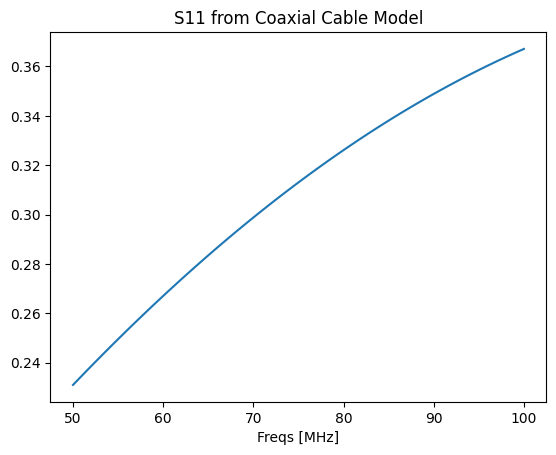

In [24]:
plt.plot(sparams_from_coax.freqs, np.abs(sparams_from_coax.s11), label='|S11| from Coax');
plt.xlabel("Freqs [MHz]")
plt.title("S11 from Coaxial Cable Model");

For even more convenience, several particular coaxial cables of common components are pre-defined:

In [26]:
list(sp.KNOWN_CABLES.keys())

['balun-tube',
 'lowband-balun-tube',
 'midband-balun-tube',
 'SC3792 Connector',
 'SMA Connector',
 'UT-141C-SP',
 'UT-086C-SP',
 'Molex WM10479']

In [ ]:
sma_sparams = sp.KNOWN_CABLES['SMA Connector'].as_transmission_line(
    freqs=transmission_line.freqs
).scattering_parameters()

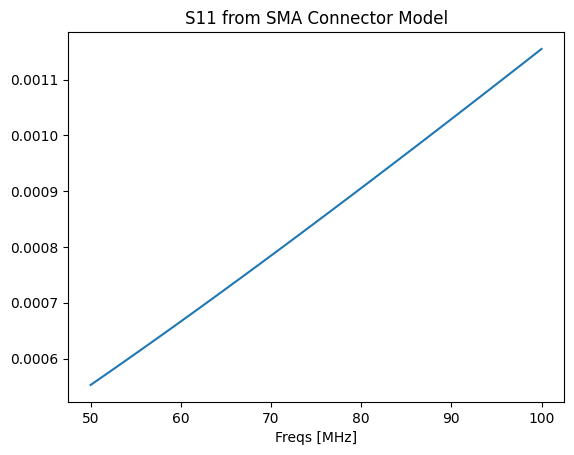

In [29]:
plt.plot(sma_sparams.freqs, np.abs(sma_sparams.s11), label='|S11| from SMA Connector')
plt.xlabel("Freqs [MHz]")
plt.title("S11 from SMA Connector Model");

## Using Calibration Standards

It is common to use calibration standards, such as open, short, and load standards, to calibrate measurement systems. The `edges.cal.sparams` module includes predefined models for these standards, allowing users to easily incorporate them into their calibration routines. 

A CalkitStandard is modeled as having a small "offset" which is a small length of transmission line. The impedance, delay, and loss of this offset can be specified when creating the standard.

For example, an open standard can be represented as follows:

In [38]:
match_standard = sp.CalkitStandard.match(
    offset_impedance=50.0 * un.ohm,
    offset_delay=30*un.picosecond, 
    offset_loss=2.1 * un.Gohm/un.s,
)

The reflection coefficient of the standard can then be computed over a specified frequency range:

In [41]:
rc_match = match_standard.reflection_coefficient(freqs=np.linspace(50,100,101)*un.MHz)

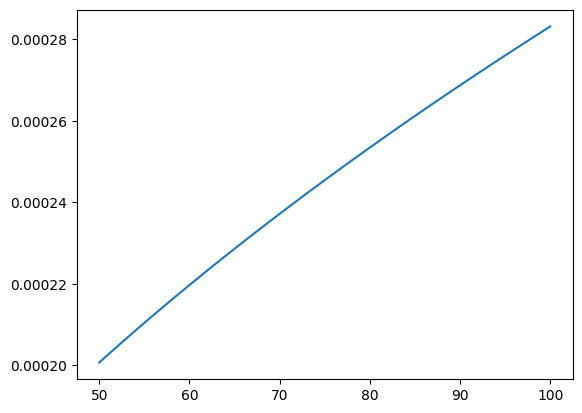

In [42]:
plt.plot(rc_match.freqs, np.abs(rc_match.reflection_coefficient), label='|Reflection Coefficient| from Match Standard')

To define a full `Calkit` of standards, we can use the `Calkit` class, which aggregates multiple `CalkitStandard` objects. This allows us to create a complete calibration kit for our measurement system.

In [45]:
calkit = sp.Calkit(
    open = sp.CalkitStandard.open(resistance=1e12*un.ohm),
    short = sp.CalkitStandard.short(),
    match = sp.CalkitStandard.match(),
)

This _model_ can be evaluated at a set of frequencies, to yield a `CalkitReadings` object:

In [47]:
calkit_readings = calkit.at_freqs(freqs=np.linspace(50,100,101)*un.MHz)

We will see later that this object is quite useful.

## Calibrating Reflection Coefficients

Measurements of reflection coefficients are defined relative to a reference plane, which may not coincide with the physical interface of the device under test (DUT). To account for this, we can use calibration techniques to shift the reference plane to the desired location.

To shift the reference plane of a reflection coefficient measurement, we can use the `de_embed` method provided by the `ReflectionCoefficient` class. This method moves the reference plane from one location in the network to another, where
the intervening network is represented by its S-parameters.

So, for example we have the `rc_match` reflection coefficient defined above. Let's
assume that an SMA Connector is attached to this device, and we want to move the reference
plane to the end of the connector. We can do this as follows:

In [49]:
rc_match_deembedded = rc_match.de_embed(sma_sparams)

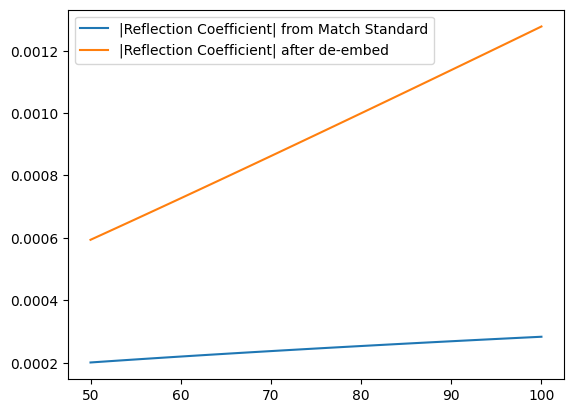

In [50]:
plt.plot(rc_match.freqs, np.abs(rc_match.reflection_coefficient), label='|Reflection Coefficient| from Match Standard')
plt.plot(rc_match.freqs, np.abs(rc_match_deembedded.reflection_coefficient), label='|Reflection Coefficient| after de-embed')
plt.legend()

One important way to compute the S-parameters of a subsystem
is to use the "one-port direct/reverse" method, which uses
measurements of a known standard to compute the S-parameters of
the subsystem (Monsalve+2016). This requires measurements of the
Calkit standards (with a VNA), as well as a model of the intrinsic
reflection coefficients of the standards. 

We have a couple of particular Calkit standards built-in for convenience.
Let's use one of these to define a (mock) set of measurements:

In [51]:
calkit_model = sp.AGILENT_85033E
calkit_meas = calkit_model.at_freqs(freqs=np.linspace(50,100,101)*un.MHz)

Now, to compute the S-parameters of a subsystem through which
these measurements were made when terminated with the calkit standards, we can use a simple method on the `SParams` class:

In [52]:
solved_sparams = sp.SParams.from_calkit_measurements(model=calkit_model, measurements=calkit_meas)

These S-parameters can then be used for further analysis or de-embedding as needed.